In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../global_variables.py ./
%run ../global_functions.py ./

In [2]:
%matplotlib notebook

basins=load_basins_data()
#basins=geopandas.read_file('../datasets/basins/amazon_subbasins.shp')
#basins.set_index('NAME',inplace=True)

In [3]:
Nbasins=basins.shape[0]
Ndatasets=1694
data_TWS='GRACE_CSR_mascons'
min_year=2003
max_year=2014

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

# 1. NSE statistics

In [5]:
NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])

## 1.1. Maximum NSE over all combinations

<IPython.core.display.Javascript object>


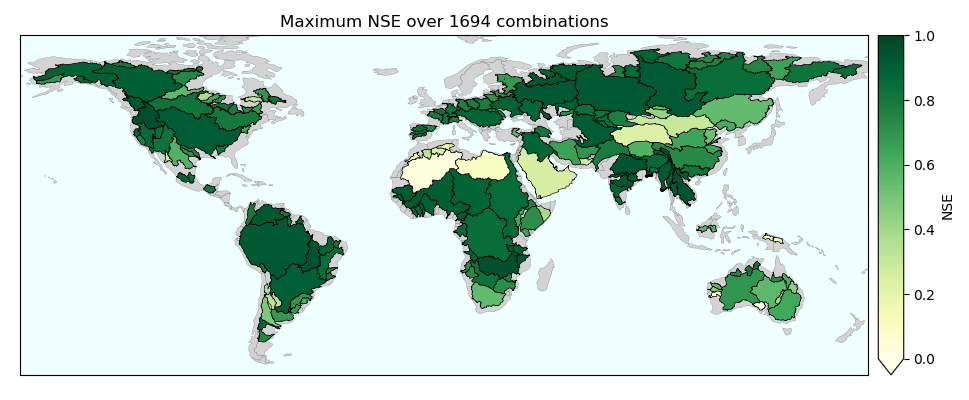

In [6]:
basins_plot=basins.copy()
basins_plot['max NSE']=np.nanmax(NSE_tab.loc[basins.index],axis=1)

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column='max NSE',edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('YlGn'),
                 vmin=0,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "NSE",
                              'extend':'min'
                          },)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,80])
ax.set_title('Maximum NSE over {} combinations'.format(Ndatasets))
plt.tight_layout()
plt.show()

Compute the maximum NSE over all basins and the area in millions km^2

In [7]:
max_NSE=pd.Series(np.nanmax(NSE_tab,axis=1),index=NSE_tab.index,name='max NSE').to_frame()
max_NSE['area']=basins['geometry'].to_crs('epsg:6933').area/1e12
max_NSE

,max NSE,area
NAME,,
WINISK,0.707053,0.065911
COPPER,0.848389,0.066095
NOTTAWAY,0.729137,0.066270
TALAS,0.856672,0.066308
MARONI,0.889944,0.066116
...,...,...
Tibetan plateau,0.589940,0.590534
Western Plateau,0.692330,1.993775
Puna de Atacama plateau,0.378147,0.101636


<IPython.core.display.Javascript object>


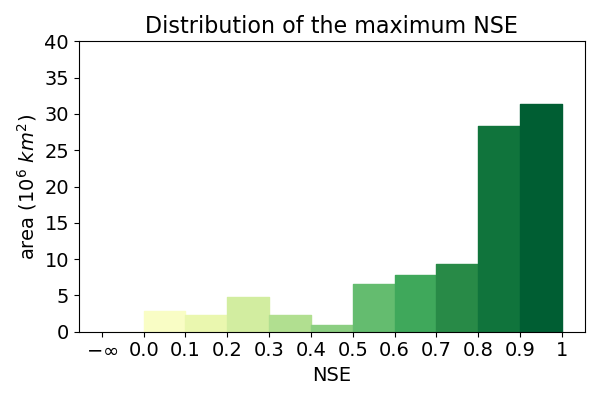

In [8]:
cmap = plt.get_cmap('YlGn')(np.linspace(0,1,12))
step=0.1
bins=np.arange(0,1,step)

plt.figure(figsize=(6,4))
# all basins below the lower bound
bound=bins[0]
area_basins=max_NSE.loc[max_NSE['max NSE']<bound,'area'].sum()
plt.fill_between([bound-step,bound],[0,0],[area_basins,area_basins],
                    color=cmap[0])

for i,bound in enumerate(bins):
    area_basins=max_NSE.loc[(max_NSE['max NSE']>=bound)&(max_NSE['max NSE']<bound+step),'area'].sum()
    plt.fill_between([bound,bound+step],[0,0],[area_basins,area_basins],
                    color=cmap[i+1])
#plt.xlim([-0.1,1])
plt.ylim([0,40])
plt.xticks([bins[0]-step]+list(bins)+[1],[r'$- \infty$']+list(np.round(bins,1))+[1],fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('NSE',fontsize=14)
plt.ylabel('area ($10^6$ $km^2$)',fontsize=14)
plt.title('Distribution of the maximum NSE',fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
thresh=0.8
area=max_NSE.loc[max_NSE['max NSE']>=thresh,'area'].sum()
print('{:.1f} million km2 with NSE >= {}, represents {:.1f}% of the total area'.format(area,
                                                        thresh,100*area/max_NSE['area'].sum()))

59.7 million km2 with NSE >= 0.8, represents 61.7% of the total area


## 1.2. Combinations ranking

In [10]:
# Function to calculate weighted median
def weightedPercentile(arr, W, perc=0.5):
    nonan=np.where(~np.isnan(arr))[0]
    arr=arr.iloc[nonan]
    W=W.iloc[nonan]
    W=W/W.sum()
    
    # Store pairs of arr[i] and W[i]
    pairs = []
    for element,weight in zip(arr,W):
        pairs.append([element, weight])

    # Sort the list of pairs w.r.t.
    # to their arr[] values
    pairs.sort(key = lambda p: p[0])

    # If N is odd
    if arr.shape[0] % 2 != 0:
        # Traverse the set pairs from left to right until the sum reaches 0.5
        sums = 0
        i=0 # index of elements
        while sums<=perc:
            sums+=pairs[i][1] # next weight
            i+=1
        return pairs[i-1][0] # corresponding element

    # If N is even
    else:
        # For lower median traverse the set pairs from left
        sums = 0
        i=0 # index of elements
        while sums<perc:
            sums+=pairs[i][1] # next weight
            i+=1
        lower_median=pairs[i-1][0] # corresponding element

        # For upper median traverse the set pairs from right
        sums = 0
        i=len(pairs)-1 # index of elements
        while sums<1-perc:
            sums+=pairs[i][1] # next weight
            i-=1
        upper_median=pairs[i+1][0] # corresponding element
        
        return (upper_median+lower_median)/2

<IPython.core.display.Javascript object>


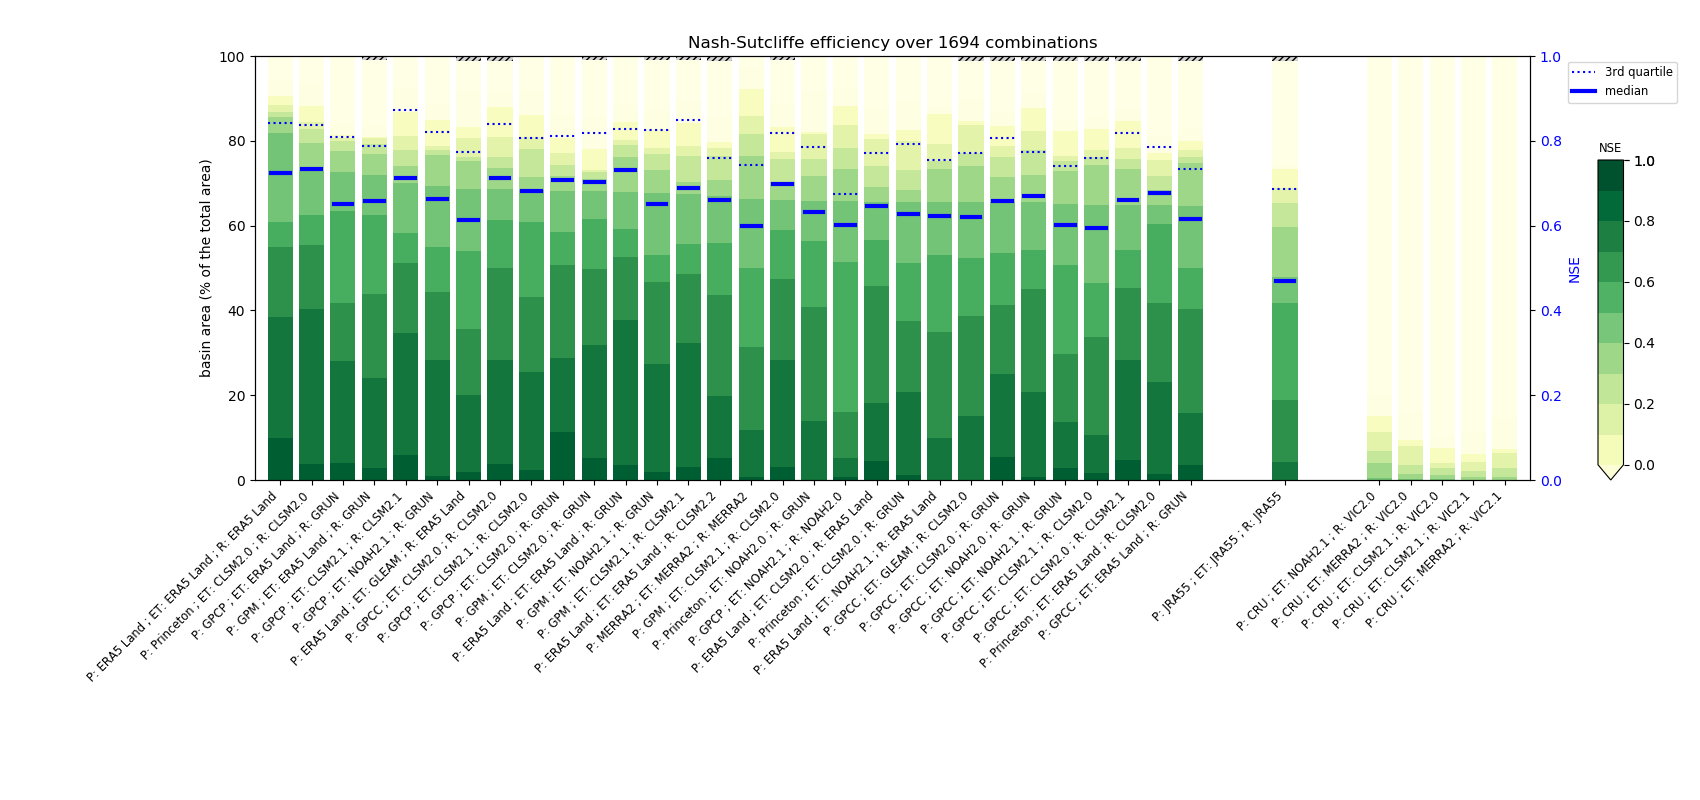

In [11]:
area=True # whether to compute the percentage area or the number of basins
total_area=np.sum(basins['RASTAREA'])
limitsNSE=list(np.arange(1,-0.1,-0.1))
my_cmap = plt.cm.get_cmap('YlGn')

# compute the number of basins in each NSE category for all datasets
if area:
    nb_very_good=np.sum(basins['RASTAREA'].to_frame().values*(NSE_tab>=0.7),axis=0)
    nb_good=np.sum(basins['RASTAREA'].to_frame().values*(NSE_tab>=0.5),axis=0)
else:
    nb_very_good=np.sum(NSE_tab>=0.7,axis=0)
    nb_good=np.sum(NSE_tab>=0.5,axis=0)

datasets_perf=nb_very_good.to_frame(name='very good')
datasets_perf['good']=nb_good

# sort datasets combinations per decreasing number of basins at least good
plot_good=30
plot_bad=5
sorted_datasets=list(datasets_perf.sort_values(by=['good','very good'],ascending=False).index[:plot_good])
xdatasets=list(np.arange(plot_good))

# add reanalyses
for my_combination in ['P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS),
                       'P_MERRA2_ET_MERRA2_R_MERRA2_TWS_{}'.format(data_TWS),
                      'P_JRA55_ET_JRA55_R_JRA55_TWS_{}'.format(data_TWS)]:
    if not(my_combination in sorted_datasets):
        sorted_datasets.append(my_combination)
        xdatasets.append(xdatasets[-1]+3)

sorted_datasets+=list(datasets_perf.sort_values(by=['good','very good'],ascending=False).index[-plot_bad:])
xdatasets+=list(np.arange(xdatasets[-1]+3,xdatasets[-1]+3+plot_bad))

sorted_NSE_tab=NSE_tab[sorted_datasets]
nb_basins=sorted_NSE_tab.shape[0]
nb_datasets=sorted_NSE_tab.shape[1]

width=0.8

fig, ax1 = plt.subplots(figsize=(17,8))

bottom=np.zeros(nb_datasets)
for lim in limitsNSE:
    if area:
        basinsNSE=100*np.sum(basins['RASTAREA'].to_frame().values*(sorted_NSE_tab>=lim),axis=0)/total_area-bottom
    else:
        basinsNSE=100*np.sum(sorted_NSE_tab>=lim,axis=0)/nb_basins-bottom
    ax1.bar(xdatasets,basinsNSE,width,bottom=bottom,color=my_cmap(lim+0.01))
    bottom+=basinsNSE

# poorest performance
if area:
    basinsNSE=100*np.sum(basins['RASTAREA'].to_frame().values*(sorted_NSE_tab<lim),axis=0)/total_area
else:
    basinsNSE=100*np.sum(sorted_NSE_tab<lim,axis=0)/nb_basins
ax1.bar(xdatasets,basinsNSE,width,bottom=bottom,color=my_cmap(0))
bottom=bottom+basinsNSE

ax1.bar(xdatasets,100-bottom,width,
        bottom=bottom,color='lightgrey',hatch='/////')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# plot medians
if area:
    list_medians=[]
    for comb in sorted_NSE_tab.columns:
        list_medians.append(weightedPercentile(sorted_NSE_tab[comb], basins['RASTAREA'], perc=0.5))
    for i,med in zip(xdatasets,list_medians):
        line1,=ax2.plot([i-(width-0.2)/2,i+(width-0.2)/2],[med,med],'b',linewidth=3)
        
    list_percentiles=[]
    for comb in sorted_NSE_tab.columns:
        list_percentiles.append(weightedPercentile(sorted_NSE_tab[comb], basins['RASTAREA'], perc=0.75))
    for i,med in zip(xdatasets,list_percentiles):
        line2,=ax2.plot([i-(width)/2,i+(width)/2],[med,med],'b:')   
    
else:
    for i,med in zip(xdatasets,sorted_NSE_tab.median(axis=0)):
        line1,=ax2.plot([i-(width-0.2)/2,i+(width-0.2)/2],[med,med],'b',linewidth=3)
    for i,med in zip(xdatasets,sorted_NSE_tab.quantile(0.75,axis=0)):
        line2,=ax2.plot([i-(width)/2,i+(width)/2],[med,med],'b:')

ax2.legend([line2,line1],['3rd quartile','median'],loc='upper right', bbox_to_anchor=(1.12, 1.),fontsize='small')
ax2.set_ylim([0,1])
ax2.set_ylabel('NSE',color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax1.set_xticks(xdatasets)
formatted_combinations=[]
for comb in sorted_NSE_tab.columns:
    formatted_combinations.append(format_combination(comb))
ax1.set_xticklabels(formatted_combinations,rotation=45,ha='right',fontsize='small')
ax1.set_xlim([-width,xdatasets[-1]+width])
ax1.set_ylim([0,100])

plt.title('Nash-Sutcliffe efficiency over {} combinations'.format(Ndatasets))
if area:
    ax1.set_ylabel('basin area (% of the total area)')  
else:
    ax1.set_ylabel('number of basins (%)')  


fig.subplots_adjust(left=0.15,bottom=0.4, right=0.9, top=0.93)
cax = plt.axes([0.94, 0.4, 0.015, 0.4])
    
clb=fig.colorbar(
        ScalarMappable(cmap=plt.cm.get_cmap('YlGn'), norm=plt.Normalize(-0.1,1)),
        cax=cax,
        fraction=0.01,
        boundaries=[-0.1] + limitsNSE[::-1] + [1],  # Adding values for extensions.
        extend='min',
        ticks=[-0.1]+limitsNSE[::-1][::2]+[1],
        spacing='proportional',
    )
clb.ax.set_title('NSE',fontsize='small') 
plt.show()

## Performances of a given combination

<IPython.core.display.Javascript object>


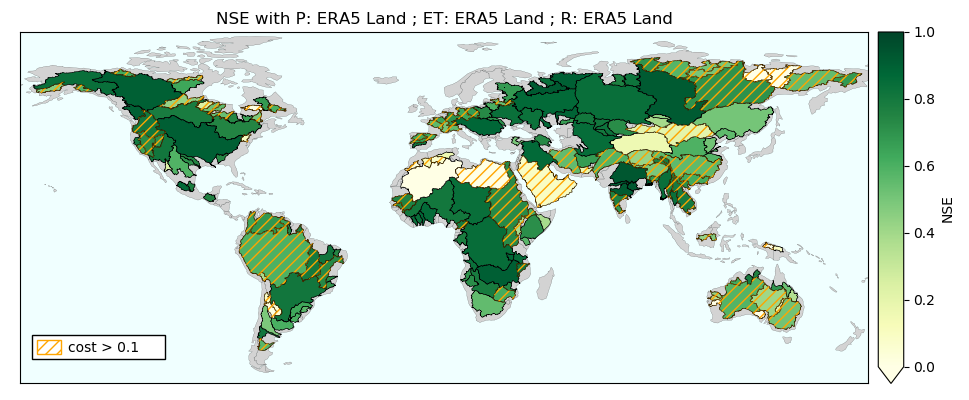

In [12]:
comb='P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS)
#comb='P_MERRA2_ET_MERRA2_R_MERRA2_TWS_{}'.format(data_TWS)
#comb='P_JRA55_ET_JRA55_R_JRA55_TWS_{}'.format(data_TWS)
#comb='P_ERA5_Land_ET_GLDAS22_CLSM25_R_GLDAS22_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_NOAH36_R_GLDAS21_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_VIC412_R_GLDAS21_VIC412_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_NOAH36_R_GLDAS20_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_VIC412_R_GLDAS20_VIC412_TWS_{}'.format(data_TWS)
#comb='P_GPM_ET_ERA5_Land_R_GRUN_TWS_{}'.format(data_TWS)

max_cost=0.1

basins_plot=basins.copy()
basins_plot[comb]=NSE_tab[comb]
basins_plot['diff']=np.nanmax(NSE_tab,axis=1)-NSE_tab[comb]

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column=comb,edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('YlGn'),
                 vmin=0,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "NSE",
                              'extend':'min'
                          },)

basins_plot.loc[basins_plot['diff']>max_cost].boundary.plot(ax=ax,color='orange',linewidth=0.1,hatch='///')
ax.fill([-165,-110,-110,-165],[-50,-50,-40,-40],facecolor='white',edgecolor='black')
ax.fill([-163,-153,-153,-163],[-48,-48,-42,-42],facecolor='white',edgecolor='orange',hatch='///')
ax.text(-150,-47,'cost > {}'.format(max_cost),fontsize=10)

ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('NSE with {}'.format(format_combination(comb)))
plt.tight_layout()
plt.show()

# 2. cyclic NSE statistics

In [13]:
NSEc_tab=pd.read_csv("../results/water_budget/NSE_cyclic_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])

## 2.1. Maximum NSE over all combinations

<IPython.core.display.Javascript object>


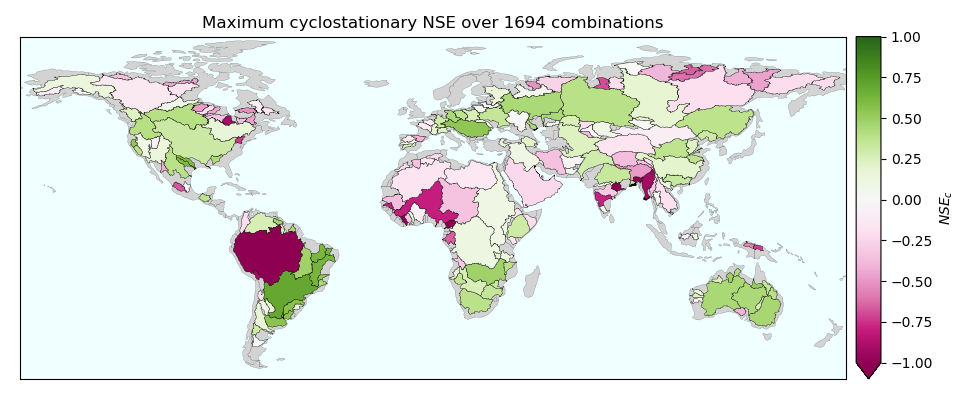

In [14]:
basins_plot=basins.copy()
basins_plot['max NSEc']=np.nanmax(NSEc_tab.loc[basins.index],axis=1)

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column='max NSEc',edgecolor='black',linewidth=0.2,
                 cmap=plt.cm.get_cmap('PiYG'),
                 vmin=-1,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "$NSE_c$",
                              'extend':'min'
                          },)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('Maximum cyclostationary NSE over {} combinations'.format(Ndatasets))
plt.tight_layout()
plt.show()

In [15]:
max_NSEc=pd.Series(np.nanmax(NSEc_tab,axis=1),index=NSEc_tab.index,name='max NSEc').to_frame()
max_NSEc['area']=basins['geometry'].to_crs('epsg:6933').area/1e12
max_NSEc['nb positive comb']=np.sum(NSEc_tab>=0,axis=1)
max_NSEc

,max NSEc,area,nb positive comb
NAME,,,
WINISK,-0.444613,0.065911,0
COPPER,-0.007243,0.066095,0
NOTTAWAY,-0.374105,0.066270,0
TALAS,-0.382643,0.066308,0
MARONI,0.447095,0.066116,57
...,...,...,...
Tibetan plateau,-0.353455,0.590534,0
Western Plateau,0.447469,1.993775,329
Puna de Atacama plateau,-0.156800,0.101636,0


<IPython.core.display.Javascript object>


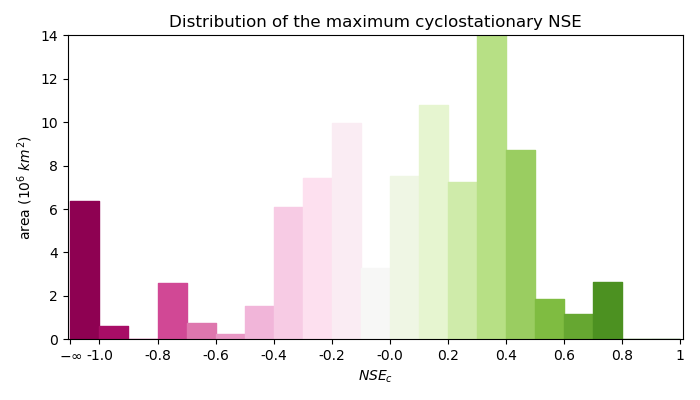

In [16]:
cmap = plt.get_cmap('PiYG')(np.linspace(0,1,21))
step=0.1
bins=np.arange(-1,1,step)

plt.figure(figsize=(7,4))
# all basins below the lower bound
bound=bins[0]
area_basins=max_NSEc.loc[max_NSEc['max NSEc']<bound,'area'].sum()
plt.fill_between([bound-step,bound],[0,0],[area_basins,area_basins],
                    color=cmap[0])

for i,bound in enumerate(bins):
    area_basins=max_NSEc.loc[(max_NSEc['max NSEc']>=bound)&(max_NSEc['max NSEc']<bound+step),'area'].sum()
    plt.fill_between([bound,bound+step],[0,0],[area_basins,area_basins],
                    color=cmap[i+1])
plt.xlim([bins[0]-step-0.01,1.01])
plt.ylim([0,14])
plt.xticks([bins[0]-step]+list(bins[::2])+[1],[r'$- \infty$']+list(np.round(bins[::2],1))+[1])
plt.xlabel('$NSE_c$')
plt.ylabel('area ($10^6$ $km^2$)')
plt.title('Distribution of the maximum cyclostationary NSE')
plt.tight_layout()
plt.show()

In [17]:
threshold=0.
print('maximum cyclic NSE >= {} in {} basins ({:.0f}% of {})'.format(threshold,
                        max_NSEc.loc[max_NSEc['max NSEc']>=threshold].shape[0],
                        100*max_NSEc.loc[max_NSEc['max NSEc']>=threshold].shape[0]/NSEc_tab.shape[0],
                        NSEc_tab.shape[0]))
print('maximum cyclic NSE >= {} in {:.1f} million km^2 ({:.0f}% of {:.1e})'.format(threshold,
                        max_NSEc.loc[max_NSEc['max NSEc']>=threshold,'area'].sum(),
                        100*max_NSEc.loc[max_NSEc['max NSEc']>=threshold,'area'].sum()/max_NSEc['area'].sum(),
                        max_NSEc['area'].sum()))

maximum cyclic NSE >= 0.0 in 106 basins (56% of 189)
maximum cyclic NSE >= 0.0 in 57.7 million km^2 (60% of 9.7e+01)


## 2.2. NSE with a given combination

<IPython.core.display.Javascript object>


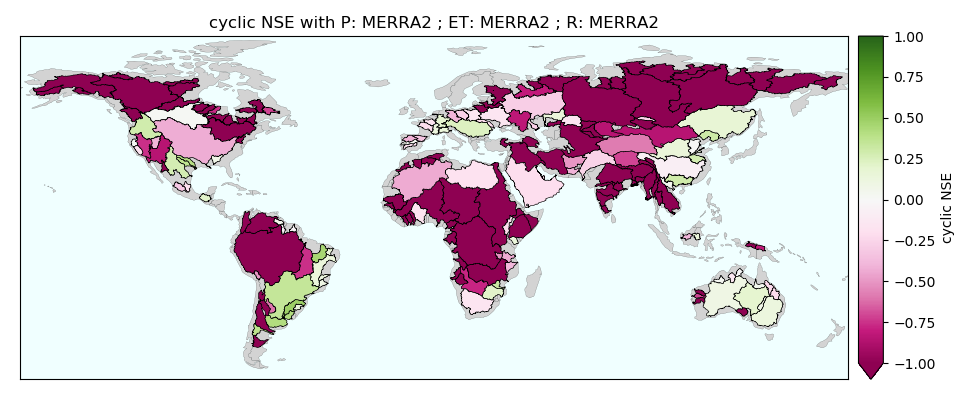

In [10]:
#comb='P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS)
comb='P_MERRA2_ET_MERRA2_R_MERRA2_TWS_{}'.format(data_TWS)
#comb='P_JRA55_ET_JRA55_R_JRA55_TWS_{}'.format(data_TWS)
#comb='P_ERA5_Land_ET_GLDAS22_CLSM25_R_GLDAS22_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_NOAH36_R_GLDAS21_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_VIC412_R_GLDAS21_VIC412_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_NOAH36_R_GLDAS20_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_VIC412_R_GLDAS20_VIC412_TWS_{}'.format(data_TWS)


basins_plot=basins.copy()
basins_plot[comb]=NSEc_tab[comb]
basins_plot['diff']=np.nanmax(NSEc_tab,axis=1)-NSEc_tab[comb]

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins_plot.plot(ax=ax,column=comb,edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('PiYG'),
                 vmin=-1,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "cyclic NSE",
                              'extend':'min'
                          },)

ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('cyclic NSE with {}'.format(format_combination(comb)))
plt.tight_layout()
plt.show()

# 3. Combine NSE and NSE cyclic

In [5]:
NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
NSEc_tab=pd.read_csv("../results/water_budget/NSE_cyclic_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
max_NSE=NSE_tab.max(axis=1)
max_NSEc=NSEc_tab.max(axis=1)

## 3.1. Maps

<IPython.core.display.Javascript object>


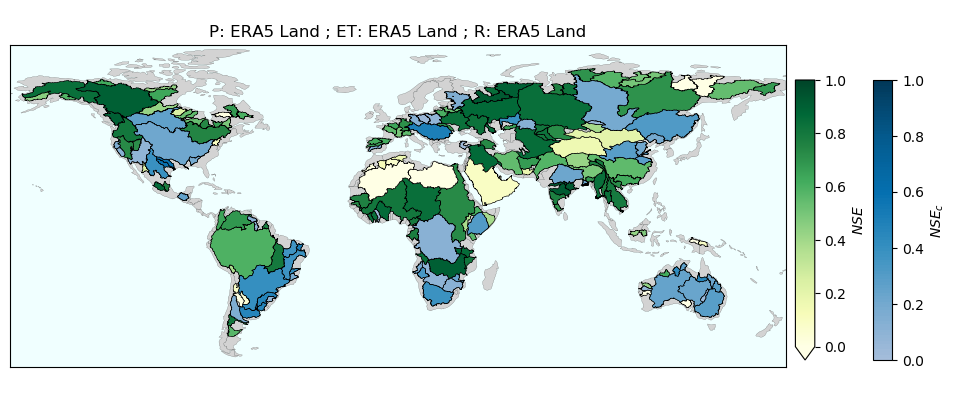

In [18]:
comb='P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS)
#comb='P_ERA5_Land_ET_ERA5_Land_R_GRUN_TWS_{}'.format(data_TWS)
#comb='P_MERRA2_ET_MERRA2_R_MERRA2_TWS_{}'.format(data_TWS)
#comb='P_JRA55_ET_JRA55_R_JRA55_TWS_{}'.format(data_TWS)
#comb='P_ERA5_Land_ET_ERA5_Land_R_GLDAS22_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_NOAH36_R_GLDAS21_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_VIC412_R_GLDAS21_VIC412_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_NOAH36_R_GLDAS20_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_VIC412_R_GLDAS20_VIC412_TWS_{}'.format(data_TWS)


basins_plot=basins.copy()
basins_plot['NSE '+comb]=NSE_tab[comb]
basins_plot['NSEc '+comb]=NSEc_tab[comb]

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal') # trick to hide the first axes behind
ax.set_xticks([])
ax.set_yticks([])
ax1=fig.add_axes([0.01, 0.01, 0.8, 0.95])

world.plot(ax=ax1,color='lightgrey',edgecolor='black',linewidth=0.1)
basins_plot.plot(ax=ax1,column='NSE '+comb,edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('YlGn'),
                 vmin=0,vmax=1)

basins_plot.loc[basins_plot['NSEc '+comb]>0].plot(ax=ax1,column='NSEc '+comb,edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('PuBu'),
                 vmin=-0.6,vmax=1,
                                                 )

cax1 = fig.add_axes([0.82, 0.1, 0.02, 0.7])
clb=fig.colorbar(
    ScalarMappable(cmap=plt.cm.get_cmap('YlGn'), norm=plt.Normalize(0,1)),
    cax=cax1,
    fraction=0.01,
    extend='min',
    label='$NSE$'
    )

cax2 = fig.add_axes([0.9, 0.1, 0.02, 0.7])
clb=fig.colorbar(
    ScalarMappable(cmap=plt.cm.get_cmap('PuBu'), norm=plt.Normalize(-0.6,1)),
    cax=cax2,
    fraction=0.01,
    label='$NSE_c$',
    boundaries=np.arange(0,1.01,0.01),  # Adding values for extensions.
    ticks=np.arange(0,1.1,0.2),
    )


ax1.set_facecolor("azure")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlim([-170,180])
ax1.set_ylim([-60,85])
ax1.set_title('{}'.format(format_combination(comb)))
#plt.tight_layout()
plt.show()

Plot with horizontal colormap

<IPython.core.display.Javascript object>


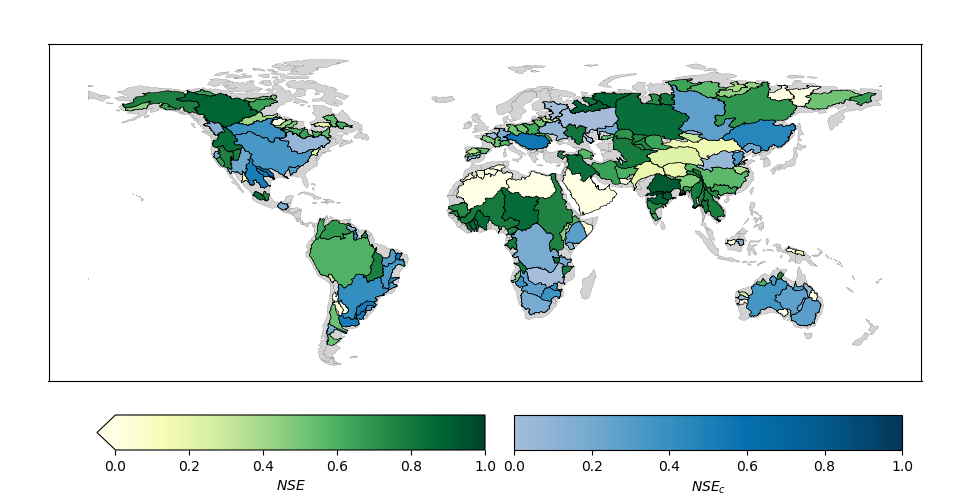

In [7]:
comb='P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS)
#comb='P_ERA5_Land_ET_ERA5_Land_R_GRUN_TWS_{}'.format(data_TWS)
#comb='P_MERRA2_ET_MERRA2_R_MERRA2_TWS_{}'.format(data_TWS)
#comb='P_JRA55_ET_JRA55_R_JRA55_TWS_{}'.format(data_TWS)
#comb='P_ERA5_Land_ET_ERA5_Land_R_GLDAS22_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_NOAH36_R_GLDAS21_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_VIC412_R_GLDAS21_VIC412_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_NOAH36_R_GLDAS20_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_VIC412_R_GLDAS20_VIC412_TWS_{}'.format(data_TWS)


basins_plot=basins.copy()
basins_plot['NSE '+comb]=NSE_tab[comb]
basins_plot['NSEc '+comb]=NSEc_tab[comb]

fig, ax = plt.subplots(figsize=(9.7,5))
ax.set_aspect('equal') # trick to hide the first axes behind
ax.set_xticks([])
ax.set_yticks([])

world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins_plot.plot(ax=ax,column='NSE '+comb,edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('YlGn'),
                 vmin=0,vmax=1)

basins_plot.loc[basins_plot['NSEc '+comb]>0].plot(ax=ax,column='NSEc '+comb,edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('PuBu'),
                 vmin=-0.6,vmax=1,
     
                                        )

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.95, top=0.95)

cax1 = fig.add_axes([0.1, 0.1, 0.4, 0.07])
clb=fig.colorbar(
    ScalarMappable(cmap=plt.cm.get_cmap('YlGn'), norm=plt.Normalize(0,1)),
    cax=cax1,
    fraction=0.01,
    orientation='horizontal',
    extend='min',
    label='$NSE$'
    )

cax2 = fig.add_axes([0.53, 0.1, 0.4, 0.07])
clb=fig.colorbar(
    ScalarMappable(cmap=plt.cm.get_cmap('PuBu'), norm=plt.Normalize(-0.6,1)),
    cax=cax2,
    fraction=0.01,
    orientation='horizontal',
    label='$NSE_c$',
    boundaries=np.arange(0,1.01,0.01),  # Adding values for extensions.
    ticks=np.arange(0,1.1,0.2),
    )


ax1.set_facecolor("azure")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlim([-170,180])
ax1.set_ylim([-60,85])
ax1.set_title('{}'.format(format_combination(comb)))
plt.show()

In [20]:
clim='BSk'
#my_index=basins.loc[basins['MAIN_CLIMATE']==clim].index

my_index=basins.index
print('Total area {}: {:.1f}'.format(climate_name_dict[clim],basins.loc[my_index,'RASTAREA'].sum()/1e6))

Total area Arid Steppe cold: 96.7


In [21]:
Ncomb=25
area=False
if area:
    df=pd.Series(np.where(NSEc_tab.loc[my_index]>0,basins.loc[my_index,'RASTAREA'].to_frame(),0).sum(axis=0)/1e6,
             name='area $NSE_c>0$',index=NSEc_tab.columns)
    df=df.to_frame()
    df['area $NSE>0$']=pd.Series(np.where(NSE_tab.loc[my_index]>0,basins.loc[my_index,'RASTAREA'].to_frame(),0).sum(axis=0)/1e6,
                                 name='area $NSE>0$',index=NSE_tab.columns)
    df.sort_values(by='area $NSE_c>0$',inplace=True,ascending=False)
    df=df.round(1)
else:
    df=np.sum(NSEc_tab.loc[my_index]>0,axis=0).sort_values(ascending=False).to_frame(name='number basins $NSE_c>0$')
    df['number basins $NSE>0$']=np.sum(NSE_tab.loc[my_index]>0,axis=0)


list_comb_names=[]
for comb in df.index:
    list_comb_names.append(format_combination(comb))
df.index=list_comb_names
short_df=df.iloc[:Ncomb]
short_df=short_df.append(pd.DataFrame([['...','...']],index=['...'],columns=df.columns))
short_df=short_df.append(df.loc['P: GPCP ; ET: NOAH2.1 ; R: NOAH2.1'])
short_df=short_df.append(pd.DataFrame([['...','...']],index=['...'],columns=df.columns))
short_df=short_df.append(df.loc['P: ERA5 Land ; ET: CLSM2.2 ; R: CLSM2.2'])
short_df=short_df.append(pd.DataFrame([['...','...']],index=['...'],columns=df.columns))
short_df=short_df.append(df.loc['P: JRA55 ; ET: JRA55 ; R: JRA55'])
short_df=short_df.append(pd.DataFrame([['...','...']],index=['...'],columns=df.columns))
short_df=short_df.append(df.loc['P: GPCP ; ET: VIC2.1 ; R: VIC2.1'])
short_df

,number basins $NSE_c>0$,number basins $NSE>0$
P: Princeton ; ET: CLSM2.0 ; R: CLSM2.0,58,177
P: ERA5 Land ; ET: ERA5 Land ; R: ERA5 Land,58,182
P: ERA5 Land ; ET: ERA5 Land ; R: GRUN,47,168
P: GPCP ; ET: CLSM2.1 ; R: CLSM2.1,45,163
P: ERA5 Land ; ET: ERA5 Land ; R: MERRA2,43,153
P: Princeton ; ET: NOAH2.0 ; R: CLSM2.0,40,169
P: GPCP ; ET: CLSM2.1 ; R: CLSM2.0,40,163
P: ERA5 Land ; ET: ERA5 Land ; R: CLSM2.2,40,153
P: GPCC ; ET: CLSM2.0 ; R: CLSM2.0,38,163
P: GPCP ; ET: ERA5 Land ; R: GRUN,36,159


In [11]:
df_latex=short_df.to_latex(escape=False)
df_latex=df_latex.replace('P: ERA5 Land ; ET: ERA5 Land ; R: ERA5 Land',
                 '\\textit{P: ERA5 Land ; ET: ERA5 Land ; R: ERA5 Land}')
df_latex=df_latex.replace('P: Princeton ; ET: CLSM2.0 ; R: CLSM2.0',
                 '\\textit{P: Princeton ; ET: CLSM2.0 ; R: CLSM2.0}')
df_latex=df_latex.replace('P: Princeton ; ET: NOAH2.0 ; R: NOAH2.0',
                 '\\textit{P: Princeton ; ET: NOAH2.0 ; R: NOAH2.0}')
df_latex=df_latex.replace('P: Princeton ; ET: VIC2.0 ; R: VIC2.0',
                 '\\textit{P: Princeton ; ET: VIC2.0 ; R: VIC2.0}')
df_latex=df_latex.replace('P: GPCP ; ET: CLSM2.1 ; R: CLSM2.1',
                 '\\textit{P: GPCP ; ET: CLSM2.1 ; R: CLSM2.1}')
df_latex=df_latex.replace('P: GPCP ; ET: NOAH2.1 ; R: NOAH2.1',
                 '\\textit{P: GPCP ; ET: NOAH2.1 ; R: NOAH2.1}')
df_latex=df_latex.replace('P: GPCP ; ET: VIC2.1 ; R: VIC2.1',
                 '\\textit{P: GPCP ; ET: VIC2.1 ; R: VIC2.1}')
df_latex=df_latex.replace('P: ERA5 Land ; ET: CLSM2.2 ; R: CLSM2.2',
                 '\\textit{P: ERA5 Land ; ET: CLSM2.2 ; R: CLSM2.2}')
df_latex=df_latex.replace('P: MERRA2 ; ET: MERRA2 ; R: MERRA2',
                 '\\textit{P: MERRA2 ; ET: MERRA2 ; R: MERRA2}')
df_latex=df_latex.replace('P: JRA55 ; ET: JRA55 ; R: JRA55',
                 '\\textit{P: JRA55 ; ET: JRA55 ; R: JRA55}')
print(df_latex)

\begin{tabular}{lll}
\toprule
{} & number basins $NSE_c>0$ & number basins $NSE>0$ \\
\midrule
\textit{P: Princeton ; ET: CLSM2.0 ; R: CLSM2.0}     &                      63 &                   169 \\
\textit{P: ERA5 Land ; ET: ERA5 Land ; R: ERA5 Land} &                      56 &                   171 \\
\textit{P: GPCP ; ET: CLSM2.1 ; R: CLSM2.1}          &                      49 &                   147 \\
P: ERA5 Land ; ET: ERA5 Land ; R: GRUN      &                      45 &                   157 \\
P: Princeton ; ET: NOAH2.0 ; R: CLSM2.0     &                      44 &                   158 \\
\textit{P: MERRA2 ; ET: MERRA2 ; R: MERRA2}          &                      42 &                   161 \\
P: ERA5 Land ; ET: ERA5 Land ; R: CLSM2.2   &                      40 &                   146 \\
P: GPCP ; ET: CLSM2.1 ; R: CLSM2.0          &                      40 &                   141 \\
P: MSWEP ; ET: GLEAM ; R: CLSM2.0           &                      39 &                   146

# 4. Correlation between non-seasonal components

Overrates reconstructions with large RMSE if the correlation is good. Especially, underestimation of the amplitude is not highlighted as bad.

In [22]:
deseason_corr_tab=pd.read_csv("../results/water_budget/deseason_correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])

<IPython.core.display.Javascript object>


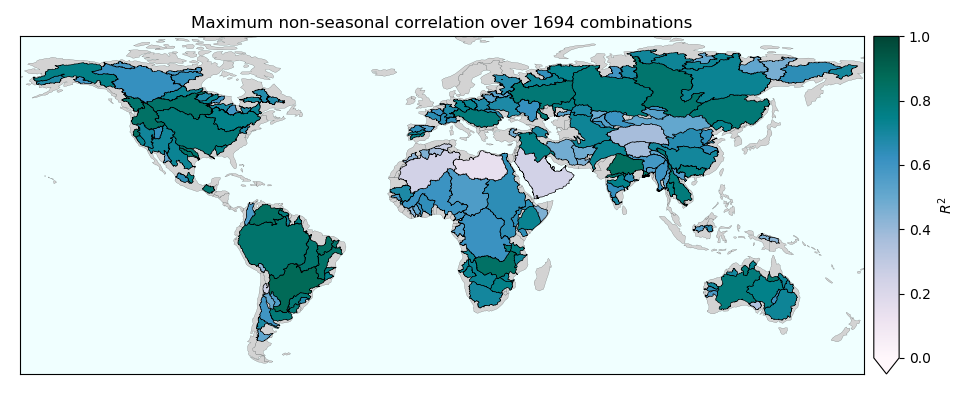

In [23]:
basins_plot=basins.copy()
basins_plot['max corr']=np.nanmax(deseason_corr_tab.loc[basins.index],axis=1)

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column='max corr',edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('PuBuGn'),
                 vmin=0,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "$R^2$",
                              'extend':'min'
                          },)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,80])
ax.set_title('Maximum non-seasonal correlation over {} combinations'.format(Ndatasets))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


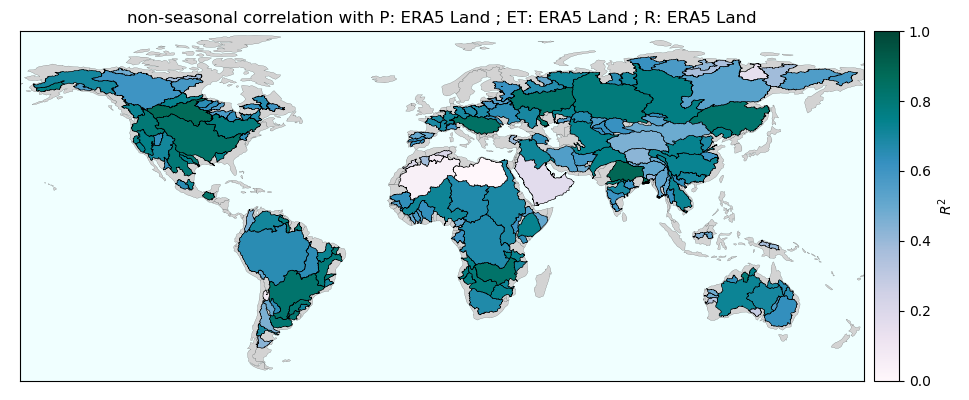

In [19]:
comb='P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS)
#comb='P_MERRA2_ET_MERRA2_R_MERRA2_TWS_{}'.format(data_TWS)
#comb='P_JRA55_ET_JRA55_R_JRA55_TWS_{}'.format(data_TWS)
#comb='P_ERA5_Land_ET_GLDAS22_CLSM25_R_GLDAS22_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_NOAH36_R_GLDAS21_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_VIC412_R_GLDAS21_VIC412_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_NOAH36_R_GLDAS20_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_VIC412_R_GLDAS20_VIC412_TWS_{}'.format(data_TWS)
#comb='P_GPM_ET_ERA5_Land_R_GRUN_TWS_{}'.format(data_TWS)

basins_plot=basins.copy()
basins_plot[comb]=deseason_corr_tab[comb]

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column=comb,edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('PuBuGn'),
                 vmin=0,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "$R^2$",
                          },)

ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('non-seasonal correlation with {}'.format(format_combination(comb)))
plt.tight_layout()
plt.show()